In [87]:
from IPython.display import display
import sys
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import geopandas as gpd
from shapely.geometry import Point
from rasterstats import zonal_stats

sys.path.append("/Users/dunstanmatekenya/OneDrive - WBG/Data-Lab/ethiopia-economic-monitoring/src")
from data_processing_utils import geoprocessing_utils as  gutils
from data_processing_utils import dataframe_utils as  utils

In [131]:
# Setup global variables and input paths
COUNTRY_CODE = "ETH"

# Input paths 
DIR_DATA = Path.cwd().parents[1].joinpath("data")
DIR_BASE_LAYERS = DIR_DATA.joinpath("base-layers")
DIR_ADM_BOUNDS = DIR_BASE_LAYERS.joinpath("adm-bounds", "from-hdx")
DIR_POP = DIR_BASE_LAYERS.joinpath("population")
DIR_META_POP = DIR_POP.joinpath("meta-pop-density")
DIR_OSM = DIR_BASE_LAYERS.joinpath("osm")
FILE_WORLDPOP_COUNTS = DIR_POP.joinpath("worldpop-pop-count/eth_ppp_2020_UNadj.tif")
FILE_OVERTURE_PLACES = DIR_BASE_LAYERS.joinpath("overture", "places.geojson")

# Basemaps for Ethiopia

## Overview

This notebook aims to download, preprocess, and display various base layers, or basemaps, for Ethiopia. The following layers will be included:

1. Administrative boundaries
2. Population
3. Places and Points of Interest (POIs)
4. Buildings
5. Roads

These basemaps have two main functions. First, they provide essential contextual information, such as demographic and infrastructure details. Second, they serve as crucial inputs for further advanced analysis in the project.

## Summary of Data Sources 
The section below provides a summary of key information about the data sources for the basemaps.

1. **Ethiopia administrative boundaries.** The administrative boundaries are available up to level 3 and the data was downloaded from **UNOCHA** or populary known as HDX
2. **Population.** THere two sources for population data: for populatoin density, we use Meta while for population counts we use WorldPop gridded population data.
3. **Places and Points of Interest (POIs)**. 
4. **Buildings**. The buildings footprints are downloaded from Overturemaps
5. **Roads**. The road network data is downloaded from **UNOCHA**


## 1. Administrative boundaries 
Administrative boundaries were downloaded from [HDX](https://data.humdata.org/dataset/cod-ab-eth). The dataset provides administrative boundaries up to level 3. According to the metadata on this page, the data originates from the **Central Statistics Agency (CSA)** and the **Regional Bureau of Finance and Economic Development (BoFED)**.


In [5]:
gdf_adm1 = gpd.read_file(DIR_ADM_BOUNDS.joinpath("eth_admbnda_adm1_csa_bofedb_2021.shp"))
gdf_adm2 = gpd.read_file(DIR_ADM_BOUNDS.joinpath("eth_admbnda_adm2_csa_bofedb_2021.shp"))
gdf_adm3 = gpd.read_file(DIR_ADM_BOUNDS.joinpath("eth_admbnda_adm3_csa_bofedb_2021.shp"))


  Ethiopia Admin-1-Regions

There are 13 regions in the HDX dataset
----------------------------------------


<Axes: >

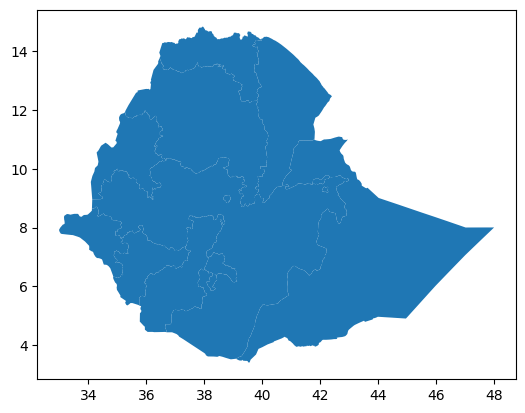

In [6]:
print("="*30)
print("  Ethiopia Admin-1-Regions")
print("="*30)
adm1_cnt = gdf_adm1.shape[0]
print()
print(f"There are {adm1_cnt} regions in the HDX dataset")
print("-"*40)

gdf_adm1.plot()

  Ethiopia Admin-2-Zones

There are 92 zones in the HDX dataset
----------------------------------------


<Axes: >

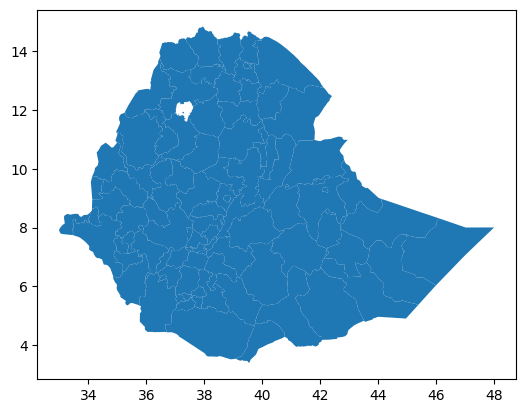

In [7]:
print("="*30)
print("  Ethiopia Admin-2-Zones")
print("="*30)
adm2_cnt = gdf_adm2.shape[0]
print()
print(f"There are {adm2_cnt} zones in the HDX dataset")
print("-"*40)

gdf_adm2.plot()


  Ethiopia Admin-3-Districts/Woredas

 There are 1082 districts in the HDX dataset
---------------------------------------------


<Axes: >

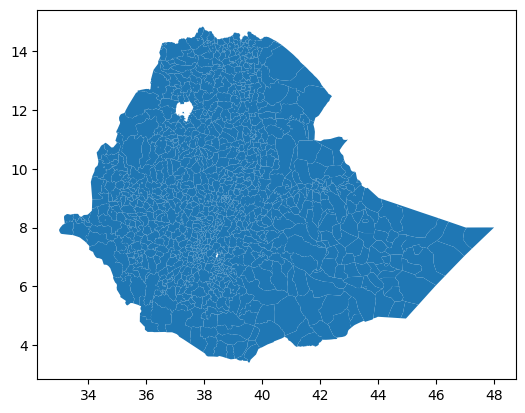

In [8]:
print("="*40)
print("  Ethiopia Admin-3-Districts/Woredas")
print("="*40)
adm3_cnt = gdf_adm3.shape[0]
print()
print(f" There are {adm3_cnt} districts in the HDX dataset")
print("-"*45)

gdf_adm3.plot()

## 2. Population
Two sources are used for population, one providing population density and the other population counts as follows.
### World Pop gridded population counts

**Data source.**(https://hub.worldpop.org/geodata/summary?id=26183). 

This data provides estimated number of people per grid cell with resolution 100m. This is 2020 population.

### Meta population density estimates 
**Data source.**. The data was downloaded from [HDX website.](https://data.humdata.org/dataset/ethiopia-high-resolution-population-density-maps-demographic-estimates)  

In partnership with the Center for International Earth Science Information Network (CIESIN) at Columbia University, Meta uses state-of-the-art computer vision techniques to identify buildings from publicly accessible mapping services to create these population datasets. These maps are available at 30-meter resolution. These maps aren’t built using Facebook data and instead rely on applying machine vision AI to satellite imagery and census information. This data is publicly accessible on their [AWS Server](https://registry.opendata.aws/dataforgood-fb-hrsl/) and detailed documentation can be found [here](https://dataforgood.facebook.com/dfg/docs/methodology-high-resolution-population-density-maps). 

The Population Data is demographically disaggregated into the following categories
* Men
* Women
* Children under 5
* Elderly
* Women of Reproductive Age (15-49)
* Youth (15-24)
* Senior

This data is available at administrative level 3.

In [63]:
def aggregate_pop_density_to_admin_regions(df_pop_dens: pd.DataFrame, gdf_adm: gpd.GeoDataFrame, 
admin_col: str, columns_to_keep: list = None) -> gpd.GeoDataFrame:
    """
    Aggregate population density to administrative regions by spatially joining population points 
    with the corresponding polygons and summing the density for each region.

    Parameters:
    df_pop_dens (pd.DataFrame): DataFrame containing population density data with 'longitude', 'latitude', and 
                                'eth_general_2020' columns (longitude and latitude represent geographical points).
    gdf_adm (gpd.GeoDataFrame): GeoDataFrame containing the administrative regions (can be any admin level).
    admin_col (str): The column name in gdf_adm that represents the administrative region for aggregation.
    columns_to_keep (list, optional): List of column names from gdf_adm to retain in the final output, in addition 
                                      to the geometry and admin column. Defaults to None.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame containing the administrative regions with aggregated population density and 
                      specified columns from gdf_adm.
    """
    
    # Convert df_pop_dens to a GeoDataFrame
    gdf_pop_dens = gpd.GeoDataFrame(df_pop_dens, 
                                    geometry=gpd.points_from_xy(df_pop_dens['longitude'], df_pop_dens['latitude']),
                                    crs="EPSG:4326")  # Assuming population density data is in WGS84 (EPSG:4326)

    # Ensure gdf_adm has CRS and convert if needed
    if not gdf_adm.crs or gdf_adm.crs.to_string() != "EPSG:4326":
        gdf_adm = gdf_adm.to_crs(epsg=4326)

    # Perform spatial join to match population points to administrative polygons using 'contains'
    gdf_joined = gpd.sjoin(gdf_pop_dens, gdf_adm, how="left", predicate="within")

    # Group by the specified admin region column and calculate total population density for each area
    adm_population_density = gdf_joined.groupby(admin_col).agg(
        pop_density=('eth_general_2020', 'sum')
    ).reset_index()

    # Select the required columns from gdf_adm: geometry, admin_col, and the specified columns to keep
    if columns_to_keep:
        columns_to_keep = columns_to_keep + ['geometry']
    else:
        columns_to_keep = [admin_col, 'geometry']

    # Merge the population density back with the gdf_adm to get it on the admin polygons
    gdf_adm_with_density = gdf_adm[columns_to_keep].merge(adm_population_density, on=admin_col, how="left")

    return gdf_adm_with_density


In [59]:
# ===================================
# GET ADM3 POP DENSITY FROM META 
# ====================================
df_pop_dens = pd.read_csv(DIR_META_POP.joinpath("eth_general_2020.csv"))
keep_cols = ['ADM3_EN', 'ADM3_PCODE', 'ADM2_EN', 'ADM1_EN', 
              'ADM0_EN']
agg_col = 'ADM3_PCODE'
df_pop_dens_adm3 = aggregate_pop_density_to_admin_regions(df_pop_dens,  
gdf_adm3, agg_col, keep_cols)

In [71]:
def aggregate_population_from_raster(gdf_adm: gpd.GeoDataFrame, raster_path: str, admin_col: str, columns_to_keep: list = None) -> gpd.GeoDataFrame:
    """
    Aggregate population counts from a raster file to administrative regions using zonal statistics.

    Parameters:
    gdf_adm (gpd.GeoDataFrame): GeoDataFrame containing the administrative regions (can be any admin level).
    raster_path (str): Path to the raster file containing population data.
    admin_col (str): The column name in gdf_adm that represents the administrative region for aggregation.
    columns_to_keep (list, optional): List of column names from gdf_adm to retain in the final output, in addition 
                                      to the geometry and admin column. Defaults to None.

    Returns:
    gpd.GeoDataFrame: GeoDataFrame containing the administrative regions with aggregated population counts 
                      and specified columns from gdf_adm.
    """
    
    # Ensure gdf_adm has a valid CRS (assuming raster and admin regions are in the same projection)
    if not gdf_adm.crs or gdf_adm.crs.to_string() != "EPSG:4326":
        gdf_adm = gdf_adm.to_crs(epsg=4326)

    # Compute zonal statistics (sum of population for each admin region)
    stats = zonal_stats(gdf_adm, raster_path, stats="sum", geojson_out=True)

    # Convert the zonal statistics result to a GeoDataFrame
    gdf_zonal_stats = gpd.GeoDataFrame.from_features(stats)

    # Rename the 'sum' column from zonal_stats to 'population_count'
    gdf_zonal_stats = gdf_zonal_stats.rename(columns={"sum": "population_count"})

    # Select the required columns from gdf_adm: geometry, admin_col, and the specified columns to keep
    if columns_to_keep:
        columns_to_keep = columns_to_keep + ['geometry']
    else:
        columns_to_keep = [admin_col, 'geometry']

    # Merge the population count with the original admin regions GeoDataFrame
    gdf_adm_with_population = gdf_adm[columns_to_keep].merge(gdf_zonal_stats[[admin_col, 'population_count']], on=admin_col, how="left")

    return gdf_adm_with_population


In [72]:
# Admin regions GeoDataFrame (gdf_adm)
result = aggregate_population_from_raster(gdf_adm3, FILE_WORLDPOP_COUNTS, 
admin_col=agg_col, columns_to_keep=keep_cols)


In [79]:
# Save this since it takes long to generate
# Save CSV
df_pop_cnts = result.drop(columns=["geometry"])
df_pop_cnts.to_csv(DIR_POP.joinpath("worldpop-pop-count", "derived_adm3-eth-ppp-2020-UNadj.csv"), index=False)

# Save Shapefile

In [103]:
def plot_population_choropleth(gdf: gpd.GeoDataFrame, 
title: str = None, target_col: str = None):
    """
    Plot a choropleth map of population counts using the provided GeoDataFrame.

    Parameters:
    gdf (gpd.GeoDataFrame): GeoDataFrame containing the geometry and population count data.
    title (str): Title for the plot. Default is "2020 Population Count by Districts".
    
    Returns:
    None
    """
    
    # Plot the GeoDataFrame with a color map based on the population count, suppressing the default legend
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Plot the population_count column using a choropleth style without a legend
    choropleth = gdf.plot(column=target_col, 
                          cmap='OrRd',  # Use a colormap like 'OrRd' (orange-red) for visualization
                          linewidth=0.8, 
                          ax=ax, 
                          edgecolor='0.8', 
                          legend=False)  # Disable automatic legend

    # Manually create the color bar with a thousand separator
    cbar = choropleth.get_figure().colorbar(choropleth.collections[0], ax=ax)
    
    # Apply thousand separator to the color bar ticks
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Set the title and other plot aesthetics
    ax.set_title(title, fontdict={'fontsize': 15}, pad=12)
    ax.set_axis_off()  # Hide the axis for a cleaner map display
    
    # Display the plot
    plt.show()

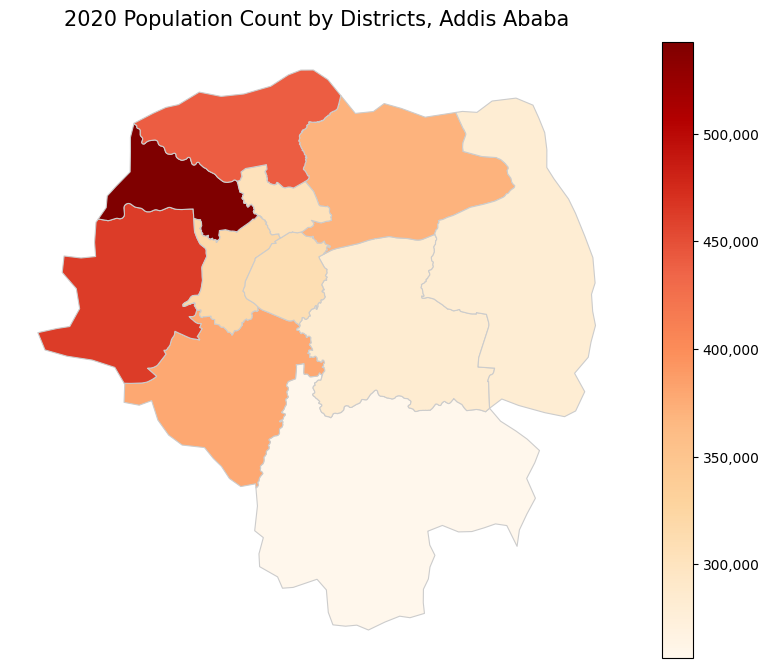

In [ ]:
# Map of population in Addis
map_title = "2020 Population Count by Districts, Addis Ababa"
df_pop_cnts_addis = result.query("ADM1_EN == 'Addis Ababa'")
plot_population_choropleth(df_pop_cnts_addis, title=map_title, 
target_col="population_count")

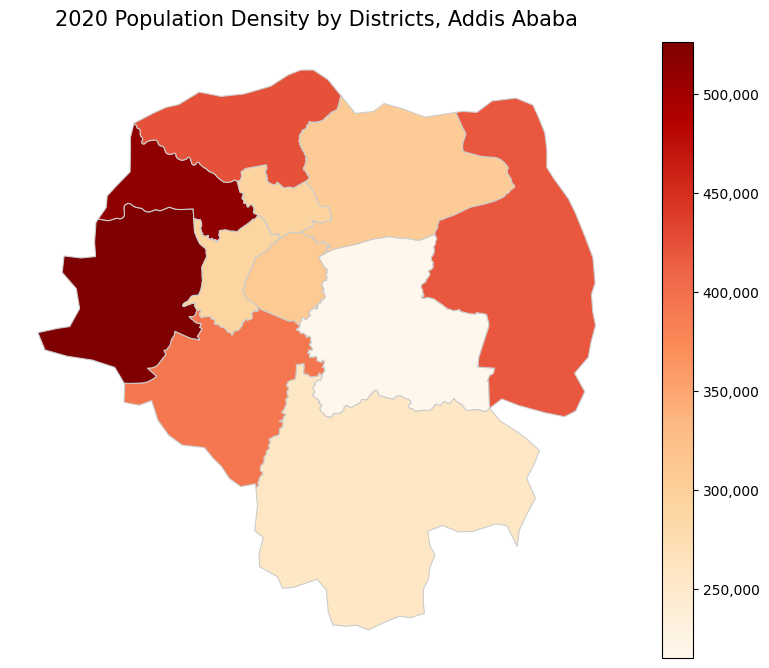

In [109]:
# Map of population density in Addis
map_title = "2020 Population Density by Districts, Addis Ababa"
df_pop_dens_addis = df_pop_dens_adm3.query("ADM1_EN == 'Addis Ababa'")
plot_population_choropleth(df_pop_dens_addis, title=map_title, 
target_col="population_density")

# 3. Points of Interest (POIs)
These are also called places. We are considering two sources for this data.

**OSM places**. OSM places refer to geographical entities such as cities, towns, villages, neighborhoods, or other types of settlements. They represent populated or named areas on the map.The two main attributes available in this dataset are *category*, for example town, city, village and *place name*.

**OSM POIs**.Refer to specific, identifiable locations that offer a service, facility, or a specific function. They represent individual objects or amenities that people might visit or interact with.

## 3.1 Summary of OSM places and POIs data

In [112]:
def pretty_print_value_counts(
    df, column, title=None, line_length=None, top_n=None, table_number=None
):
    """
    Pretty prints the value counts of a specified column in a Pandas DataFrame,
    with counts formatted with thousand separators, percentages, and cumulative percentages.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    column : str
        The name of the column for which to calculate value counts.
    title : str, optional
        A title to print above the formatted output. If None, no title is printed.
    line_length : int, optional
        The length of the separator line. If None, it will be determined based on
        the length of the title or default to 50 if no title is provided.
    top_n : int, optional
        The number of top categories to display. If None, all categories are displayed.
    table_number : int, optional
        The numeric value for the table number. If provided, the table number will be displayed as 'Table-X'.

    Returns:
    --------
    None
        Displays a styled DataFrame with counts, percentages, and cumulative percentages.
    """
    # Calculate the value counts and convert to DataFrame
    count_df = pd.DataFrame(df[column].value_counts(normalize=False).reset_index())
    count_df.columns = ["Category", "Count"]

    # Add a percentage column
    count_df["Percent"] = (count_df["Count"] / count_df["Count"].sum()) * 100

    # Add a cumulative percentage column
    count_df["Cum. Percent"] = count_df["Percent"].cumsum()

    # Limit the output to top_n categories if specified
    if top_n:
        count_df = count_df.head(top_n)

    # Print the table number if provided
    if table_number is not None:
        print(f"Table-{table_number}")

    # Determine the length of the line if line_length is not provided
    if title:
        if line_length is None:
            line_length = max(
                50, len(title) + 4
            )  # Ensure at least 50 characters, or more based on the title

        # Calculate padding to center the title
        total_padding = line_length - len(title)
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        # Print the centered title with the "=" line
        print("=" * line_length)
        print(" " * left_padding + title + " " * right_padding)
        print("=" * line_length)

    # Display the styled DataFrame without index, formatting Count, Percent, and Cumulative Percent columns
    display(
        count_df.style.hide(axis="index").format(
            {
                "Count": "{:,.0f}",  # Thousand separator for Count
                "Percent": "{:.2f}%",  # Format Percent to 2 decimal places with a % symbol
                "Cum. Percent": "{:.2f}%",  # Format Cumulative Percent to 2 decimal places with a % symbol
            }
        )
    )

    # Print footer or separator
    print("-" * line_length)

In [110]:
gdf_osm_places = gpd.read_file(DIR_OSM.joinpath("gis_osm_places_free_1.shp"))
gdf_osm_pois = gpd.read_file(DIR_OSM.joinpath("gis_osm_pois_free_1.shp"))

In [111]:
print("Number of places for Ethiopia in OSM dataset: {:,}".format(gdf_osm_places.shape[0]))
print("Number of POIs for Ethiopia in OSM dataset: {:,}".format(gdf_osm_pois.shape[0]))

Number of places for Ethiopia in OSM dataset: 24,420
Number of POIs for Ethiopia in OSM dataset: 13,205


### 3.1.1 OSM Places 

In [118]:
pretty_print_value_counts(gdf_osm_places, column="fclass", line_length=50, 
title="OSM Places Categories")

              OSM Places Categories               


Category,Count,Percent,Cum. Percent
locality,"14,442",59.14%,59.14%
hamlet,"5,413",22.17%,81.31%
village,"3,590",14.70%,96.01%
town,781,3.20%,99.21%
suburb,131,0.54%,99.74%
city,49,0.20%,99.94%
region,6,0.02%,99.97%
farm,3,0.01%,99.98%
county,2,0.01%,99.99%
island,2,0.01%,100.00%


--------------------------------------------------


In [128]:
def plot_osm_places_by_category(gdf: gpd.GeoDataFrame, category_col: str = 'fclass', title: str = "OSM Places by Category"):
    """
    Plot points from a GeoDataFrame categorized by the given column and display a legend.

    Parameters:
    gdf (gpd.GeoDataFrame): GeoDataFrame containing the geometry and category data.
    category_col (str): Column name in the GeoDataFrame representing the categories. Default is 'fclass'.
    title (str): Title for the plot. Default is "OSM Places by Category".
    
    Returns:
    None
    """
    
    # Create a plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot each category separately to ensure different colors and create a legend
    categories = gdf[category_col].unique()

    for category in categories:
        subset = gdf[gdf[category_col] == category]
        subset.plot(ax=ax, marker='o', label=category, markersize=10)

    # Add the legend and title
    plt.legend(title="Place Category")
    ax.set_title(title, fontdict={'fontsize': 15}, pad=12)
    ax.set_axis_off()  # Turn off the axis for a cleaner display
    
    # Display the plot
    plt.show()

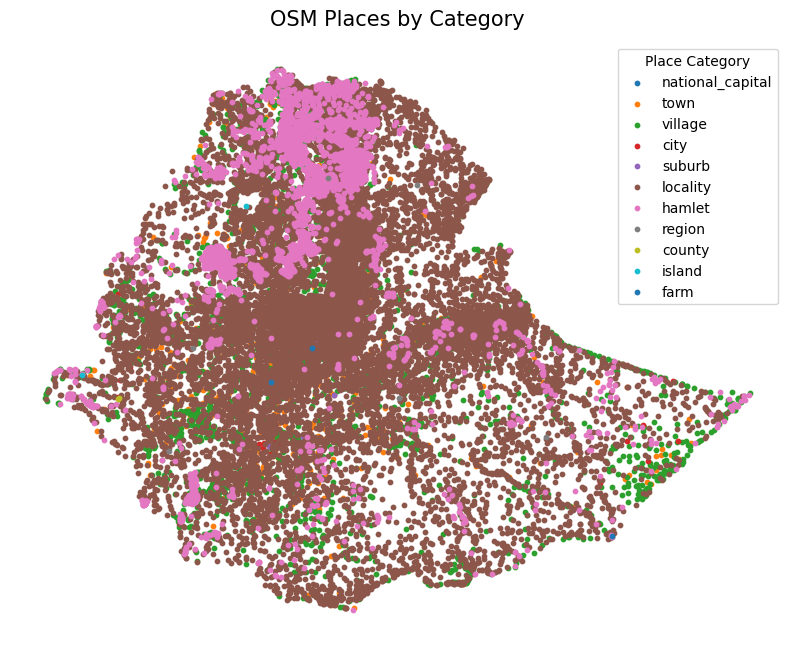

In [129]:
# ==============================
# PLOT POIS
# ===============================
plot_osm_places_by_category(gdf_osm_places)

## 3.1.2 OSM POIs

In [127]:
table_tiltle = "Top-15 Categories in OSM POIs Data"
pretty_print_value_counts(gdf_osm_pois, column="fclass", line_length=50, 
title=table_tiltle, top_n=15)

        Top-20 Categories in OSM POIs Data        


Category,Count,Percent,Cum. Percent
bank,"1,551",11.75%,11.75%
hotel,"1,244",9.42%,21.17%
restaurant,"1,010",7.65%,28.81%
school,753,5.70%,34.52%
cafe,710,5.38%,39.89%
viewpoint,597,4.52%,44.41%
toilet,486,3.68%,48.10%
attraction,405,3.07%,51.16%
comms_tower,397,3.01%,54.17%
clinic,317,2.40%,56.57%


--------------------------------------------------


## 3.2 Summary of Overture places and POIs data

In [132]:
df_ovt_places = gpd.read_file(FILE_OVERTURE_PLACES)

Skipping field websites: unsupported OGR type: 5
Skipping field socials: unsupported OGR type: 5
Skipping field phones: unsupported OGR type: 5
